# Continuing from 'Final Code Part 1', Further Analysis and Actions Below 

### Loading the Structured Data

In [14]:
import pandas as pd

# Load the dataset
dataset_path = 'Enron_emails.csv'  
df = pd.read_csv(dataset_path)


### Some basic EDA before cleaning

In [2]:
# Display the first few rows of the dataset
print(df.head())


                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# Summary of the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None


In [4]:
# Descriptive statistics for numerical features
print(df.describe())


                         file  \
count                  517401   
unique                 517401   
top     allen-p/_sent_mail/1.   
freq                        1   

                                                  message  
count                                              517401  
unique                                             517401  
top     Message-ID: <18782981.1075855378110.JavaMail.e...  
freq                                                    1  


In [5]:
# Check for missing values
print(df.isnull().sum())


file       0
message    0
dtype: int64


In [15]:
# Check for NaN values in the DataFrame
nan_values = df.isna().any()

# Display columns with NaN values
columns_with_nan = nan_values[nan_values].index.tolist()
print("Columns with NaN values:", columns_with_nan)

# Check if there are any NaN values in the DataFrame
if nan_values.any():
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")


Columns with NaN values: []
There are no NaN values in the DataFrame.


#### Observations:
- Columns: my dataset contains two columns: file and message.
- Entries: There are 517,401 entries, and each entry is unique (as indicated by the count of unique values in the file and message columns).
- No Missing Values: There are no missing values in either column.
- Message Content: The message column contains the full content of the emails, including metadata like Message-ID, Date, From, To, Subject, and the email body.

In [7]:
# Explore unique values for a message column 
print(df['message'].value_counts())


message
Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Looking on the result, the message column discusses various topics, including scheduling a review of essays, concerns about a family member's health, and logistical details about document sharing. Additionally, there's a standard confidentiality disclaimer at the end.

In terms of analysis, this email reflects typical workplace communication, including task coordination and personal concerns. It provides a glimpse into the daily interactions and dynamics within the Enron organization.

### Cleaning and Processing Steps:
Extracting Email Bodies:

The message column contains both headers (e.g., Message-ID, From, To, Subject) and the body of the emails. For autocompletion,  I am most interested in the email bodies, so I need to extract the body from each message, which typically starts after the X-FileName line or the last metadata header.

In [9]:
def extract_body(message):
    split_message = message.split('\n\n', 1)  # Splitting at the first double newline
    if len(split_message) > 1:
        return split_message[1]  # Return the part after the first double newline
    else:
        return split_message[0]  # If there's no double newline, return the whole message

# Apply the function to the 'message' column to create a new 'body' column
df['body'] = df['message'].apply(extract_body)

# Display the first few rows of the dataset to verify the extraction
print(df[['message', 'body']].head())


                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                                body  
0                          Here is our forecast\n\n   
1  Traveling to have a business meeting takes the...  
2                     test successful.  way to go!!!  
3  Randy,\n\n Can you send me a schedule of the s...  
4                Let's shoot for Tuesday at 11:45.    


Now time to clean whitespace line brake...

In [10]:
import re

def clean_text(text):
    # Replace line breaks with a space
    text = text.replace('\n', ' ')
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    return text.strip()

# Apply cleaning function to the body column
df['cleaned_body'] = df['body'].apply(clean_text)

# Display the cleaned text
print(df[['body', 'cleaned_body']].head())


                                                body  \
0                          Here is our forecast\n\n    
1  Traveling to have a business meeting takes the...   
2                     test successful.  way to go!!!   
3  Randy,\n\n Can you send me a schedule of the s...   
4                Let's shoot for Tuesday at 11:45.     

                                        cleaned_body  
0                               Here is our forecast  
1  Traveling to have a business meeting takes the...  
2                      test successful. way to go!!!  
3  Randy, Can you send me a schedule of the salar...  
4                  Let's shoot for Tuesday at 11:45.  


Then some more cleaning (punctuation, extra space, convert to lowercase and so on) and a col ro the cleaned massages

In [11]:
import re
import string

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Replace line breaks with a space
    text = text.replace('\n', ' ')
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    return text.strip()

# Apply cleaning function to the body column
df['cleaned_body'] = df['body'].apply(clean_text)

# Display the cleaned text to verify punctuation removal and normalization
print(df[['body', 'cleaned_body']].head())


                                                body  \
0                          Here is our forecast\n\n    
1  Traveling to have a business meeting takes the...   
2                     test successful.  way to go!!!   
3  Randy,\n\n Can you send me a schedule of the s...   
4                Let's shoot for Tuesday at 11:45.     

                                        cleaned_body  
0                               here is our forecast  
1  traveling to have a business meeting takes the...  
2                          test successful way to go  
3  randy can you send me a schedule of the salary...  
4                     lets shoot for tuesday at 1145  


### Save my cleaned data for a later use

In [17]:
# Save the cleaned data to a CSV file
df.to_csv('cleaned_enron_emails.csv', index=False)


Loading my clean data

In [5]:
import pandas as pd

# Load the cleaned dataset
df_emails_cleaned = pd.read_csv('cleaned_enron_emails.csv')

# Display the first few rows to confirm it's loaded correctly
print(df_emails_cleaned.head())


                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                                body  \
0                          Here is our forecast\n\n    
1  Traveling to have a business meeting takes the...   
2                     test successful.  way to go!!!   
3  Randy,\n\n Can you send me a schedule of the s...   
4                Let's shoot for Tuesday at 11:45.     

                                        cleaned_body  
0                               here is our forecast  
1  traveling to have a busine

Checking if everything looks good

In [6]:
# Display DataFrame information
print(df_emails_cleaned.info())

print(df_emails_cleaned.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   file          517401 non-null  object
 1   message       517401 non-null  object
 2   body          517401 non-null  object
 3   cleaned_body  517347 non-null  object
dtypes: object(4)
memory usage: 15.8+ MB
None
                         file  \
count                  517401   
unique                 517401   
top     allen-p/_sent_mail/1.   
freq                        1   

                                                  message  \
count                                              517401   
unique                                             517401   
top     Message-ID: <18782981.1075855378110.JavaMail.e...   
freq                                                    1   

                                                     body cleaned_body  
count                                    

### Some EDA after cleaning

C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


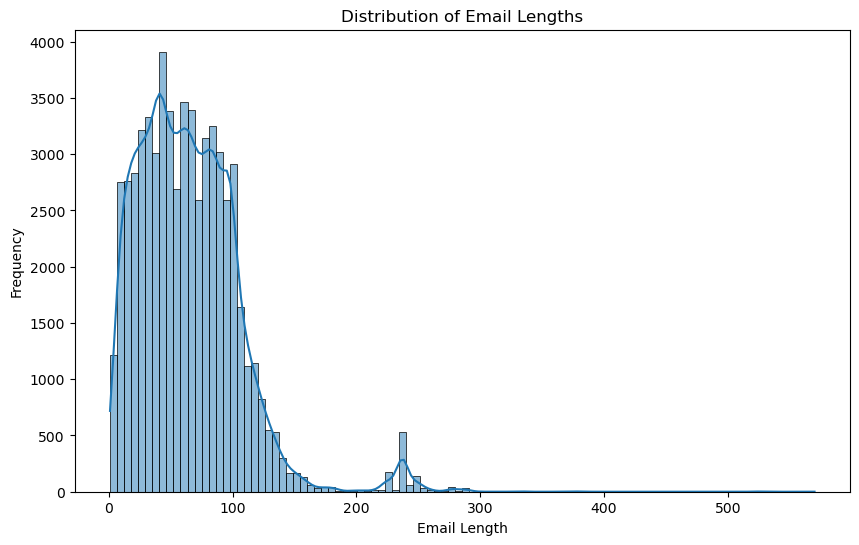

C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


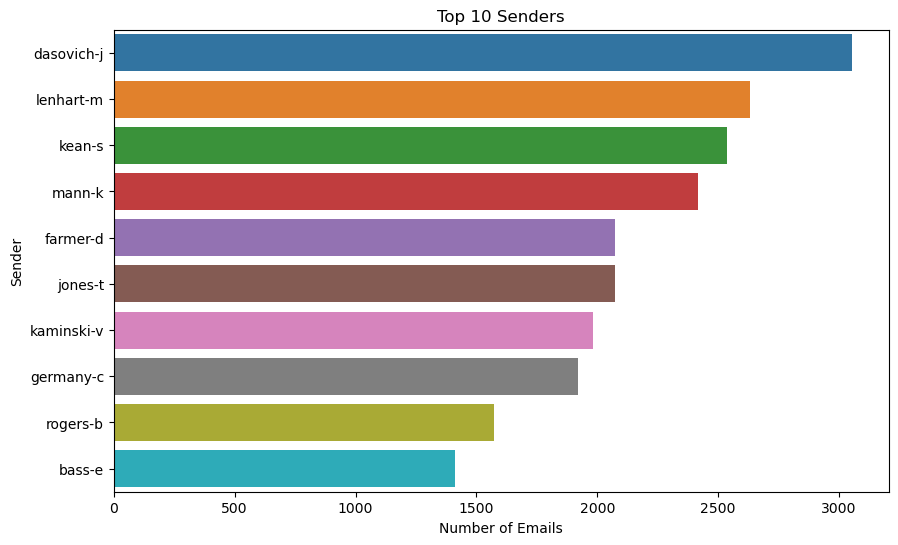

C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\17202\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

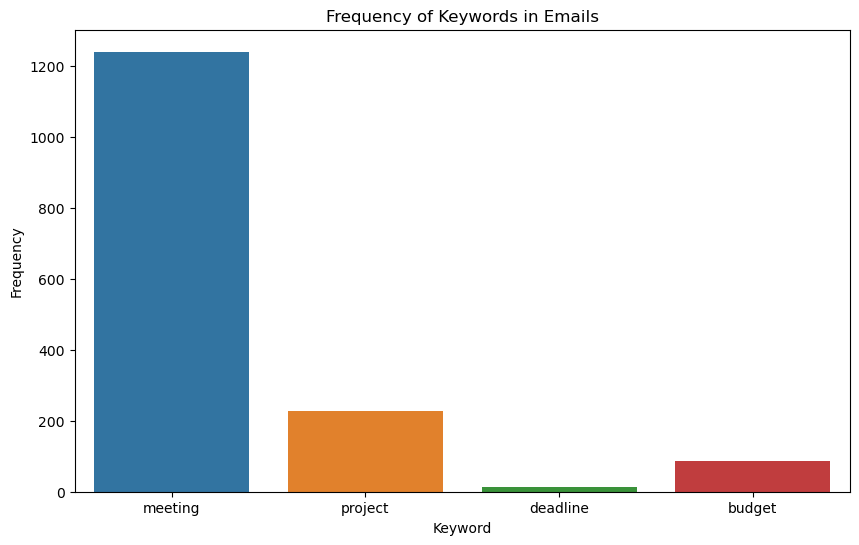

In [51]:
# Calculate email lengths for 'cleaned_body'
df_emails_cleaned['email_length'] = df_emails_cleaned['cleaned_body'].astype(str).apply(len)

# Analyze the distribution of email lengths
plt.figure(figsize=(10, 6))
sns.histplot(df_emails_cleaned['email_length'], bins=100, kde=True)
plt.title('Distribution of Email Lengths')
plt.xlabel('Email Length')
plt.ylabel('Frequency')
plt.show()


# since the sender's name is the first part of the 'file' path
df_emails_cleaned['sender'] = df_emails_cleaned['file'].apply(lambda x: x.split('/')[0])

# Plotting the top 10 senders
top_senders = df_emails_cleaned['sender'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_senders.values, y=top_senders.index)
plt.title('Top 10 Senders')
plt.xlabel('Number of Emails')
plt.ylabel('Sender')
plt.show()

# Keyword Analysis (I used 'meeting', 'project', 'deadline' and 'budget')
keywords = ['meeting', 'project', 'deadline', 'budget']  

# Initialize a dictionary to hold counts for each keyword
keyword_counts = {}

# Count occurrences of each keyword in 'cleaned_body'
for keyword in keywords:
    df_emails_cleaned[keyword] = df_emails_cleaned['cleaned_body'].astype(str).str.contains(keyword, case=False)
    keyword_counts[keyword] = df_emails_cleaned[keyword].sum()

# Plotting keyword frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
plt.title('Frequency of Keywords in Emails')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

I noted that 'meeting' is a frequently occurring term, suggesting a focus on coordination within the dataset. And the distribution of email lengths shows a strategic decision for my model's training process, it means that there needs to be a truncation process that I have to do.

## Further Preprocessing

In [17]:
import pandas as pd
import re

# Function to preprocess email body
def preprocess_email_body(body):
    # Remove quoted and forwarded messages
    body = re.sub(r"(?s)(<\w.*?>)+.*?(</\w.*?>)+", "", body)
    body = re.sub(r"(?s)(---+|===+|___+).*", "", body)
    body = re.sub(r"(?s)(On\s.*?wrote:)", "", body)
    body = re.sub(r"(?s)(On\s.*?wrote.*?wrote:)", "", body)

    # Tokenize into sentences
    sentences = re.split(r"[.!?]", body)

    # Filter out sentences longer than 20 words
    sentences = [sentence.strip() for sentence in sentences if len(sentence.split()) <= 20]

    return sentences

# Apply preprocessing to the 'cleaned_body' column
df_emails_cleaned['processed_body'] = df_emails_cleaned['cleaned_body'].apply(preprocess_email_body)

# Function to filter out long emails
def filter_long_emails(emails):
    filtered_emails = []
    for email in emails:
        # Tokenize into words
        words = email.split()
        # Remove emails longer than 100 words
        if len(words) <= 100:
            filtered_emails.append(email)
    return filtered_emails

# Apply filtering to 'processed_body' column
df_emails_cleaned['filtered_body'] = df_emails_cleaned['processed_body'].apply(filter_long_emails)

# Display the updated DataFrame
print(df_emails_cleaned.head())


                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                                body  \
0                          Here is our forecast\n\n    
1  Traveling to have a business meeting takes the...   
2                     test successful.  way to go!!!   
3  Randy,\n\n Can you send me a schedule of the s...   
4                Let's shoot for Tuesday at 11:45.     

                                        cleaned_body  cleaned_message_length  \
0                               here is our forecast       

Preprocessing: I removed quoted and forwarded messages from the email body, tokenizes it into sentences, and filters out sentences with longer words. This ensures that the input text is clean and concise, facilitating more accurate automation.

Filtering: Long emails with more than 100 words are filtered out to prevent overwhelming the automation system with excessive input, ensuring efficient processing and response generation.



In [18]:
# Drop rows where 'filtered_body' is empty
df_emails_cleaned = df_emails_cleaned[df_emails_cleaned['filtered_body'].apply(len) > 0]

# Reset index after dropping rows
df_emails_cleaned.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
print(df_emails_cleaned.head())


                       file  \
0     allen-p/_sent_mail/1.   
1   allen-p/_sent_mail/100.   
2  allen-p/_sent_mail/1001.   
3  allen-p/_sent_mail/1002.   
4  allen-p/_sent_mail/1004.   

                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <24216240.1075855687451.JavaMail.e...   
2  Message-ID: <30922949.1075863688243.JavaMail.e...   
3  Message-ID: <30965995.1075863688265.JavaMail.e...   
4  Message-ID: <17189699.1075863688308.JavaMail.e...   

                                                body  \
0                          Here is our forecast\n\n    
1                     test successful.  way to go!!!   
2                Let's shoot for Tuesday at 11:45.     
3  Greg,\n\n How about either next Tuesday or Thu...   
4                   any morning between 10 and 11:30   

                                        cleaned_body  cleaned_message_length  \
0                               here is our forecast       

I removed rows from the dataframe where the 'filtered_body' column, representing preprocessed and filtered email content, is empty. This action ensures that only emails with meaningful content are retained, enhancing data quality and reliability for subsequent analysis or automation in the project.


#### Save the filtered dataset

In [22]:
# Save the filtered DataFrame to a CSV file
df_emails_cleaned.to_csv('filtered_enron_emails.csv', index=False)



## Feature Engineering

### Step 1: Tokenization

In [27]:
# Import necessary libraries for tokenization
from nltk.tokenize import word_tokenize

# Function to tokenize a sentence
def tokenize_sentence(sentence):
    tokens = word_tokenize(str(sentence))  # Tokenize the sentence into words
    return tokens

# Apply tokenization to the 'filtered_body' column
df_emails_cleaned['tokenized_body'] = df_emails_cleaned['filtered_body'].apply(tokenize_sentence)




In [28]:
# Display the first few rows of the DataFrame with tokenized text
print(df_emails_cleaned[['filtered_body', 'tokenized_body']].head())


                                       filtered_body  \
0                             [here is our forecast]   
1                        [test successful way to go]   
2                   [lets shoot for tuesday at 1145]   
3  [greg how about either next tuesday or thursda...   
4                  [any morning between 10 and 1130]   

                                      tokenized_body  
0                [[, 'here, is, our, forecast, ', ]]  
1          [[, 'test, successful, way, to, go, ', ]]  
2    [[, 'lets, shoot, for, tuesday, at, 1145, ', ]]  
3  [[, 'greg, how, about, either, next, tuesday, ...  
4   [[, 'any, morning, between, 10, and, 1130, ', ]]  


I tokenized the filtered email bodies, converting them into a sequence of words. It utilizes the NLTK library's word_tokenize function to split each sentence into individual tokens, forming the foundation for further text analysis and feature extraction in the project.

#### Step 2: Adding a special Token

In [30]:
# Function to add special tokens <start> and <end> to a list of tokens
def add_special_tokens(tokens):
    tokens_with_special_tokens = ['<start>'] + tokens + ['<end>']
    return tokens_with_special_tokens

# Apply adding special tokens to the 'tokenized_body' column
df_emails_cleaned['body_with_special_tokens'] = df_emails_cleaned['tokenized_body'].apply(add_special_tokens)


I add special tokens <start> and <end> to each list of tokens in the 'tokenized_body' column. These tokens help the model learn the beginning and end of sequences during training.


#### Step 3: Constructing Sequence Pairs

In [31]:
# Function to split a list of tokens into pairs of input and output sequences
def create_sequence_pairs(tokens):
    sequence_pairs = []
    for i in range(1, len(tokens)):
        input_sequence = tokens[:i]  # Input sequence from start to current token
        output_sequence = tokens[i:]  # Output sequence from current token to end
        sequence_pairs.append((input_sequence, output_sequence))
    return sequence_pairs

# Apply sequence pair creation to the 'body_with_special_tokens' column
df_emails_cleaned['sequence_pairs'] = df_emails_cleaned['body_with_special_tokens'].apply(create_sequence_pairs)


Then I define a function to create_sequence_pairs that splits a list of tokens into pairs of input and output sequences. For each token in the list, it creates an input sequence from the beginning to the current token and an output sequence from the current token to the end. These sequence pairs are essential for training sequence-to-sequence models, facilitating tasks such as language translation or summarization.

In [32]:
# Count the total number of sequence pairs
total_pairs = df_emails_cleaned['sequence_pairs'].apply(len).sum()

print("Total number of sequence pairs:", total_pairs)


Total number of sequence pairs: 902983


### Saving

In [43]:
# Save the DataFrame to a CSV file
df_emails_cleaned.to_csv('emails_cleaned.csv', index=False)


# From here please refer 'Final Code Part 3- Google Colab'

# ------- >